In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy import units as un, constants as cons
from astropy.cosmology import WMAP7 as cosmo
import pandas as pd
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression
#from sklearn.model_selection import train_test_split
from scipy.interpolate import RegularGridInterpolator
from scipy.fftpack import fftn, ifftn, fftfreq

In [2]:
header_cluster = np.array(['UID', 'x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'x_pix', 'y_pix',
                           'i_sector', 'm500c[Msol/h]', 'r500c[kpc/h]', 'gas_frac',
                           'star_frac', 'T[kev]', 'Lx[1e44erg/s]', 'Y500c', 'M_sat/M_cD',
                           'cshift[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])

header_galaxy = np.array(['UID', 'x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'x_pix',
                           'y_pix', 'i_sector', 'm[Msol/h]', 'sfr[Msol/year]',
                           'host', 'dist[kpc/h]', 'log10(m_cD/m)', 'm_gas[Msol/h]',
                           'vx[km/s]', 'vy[km/s]', 'vz[km/s]', 'dv[km/s]',
                           'vr[km/s]', 'vt[km/s]'])


In [5]:
clusterfile = np.loadtxt('../Data/cluster022b.txt')
galaxyfile = np.loadtxt('../Data/galaxies022b.txt')

In [4]:
#galaxy positions
h0 = 0.704
z = 0.03 #snap140, box2hr
xg = galaxyfile[:,np.where(header_galaxy=='x[kpc/h]')[0][0]]/h0
yg = galaxyfile[:,np.where(header_galaxy=='y[kpc/h]')[0][0]]/h0
zg = galaxyfile[:,np.where(header_galaxy=='z[kpc/h]')[0][0]]/h0
pos3d_g = np.vstack((xg,yg,zg))

In [5]:
#cluster velocities & positions
xc = clusterfile[:,np.where(header_cluster=='x[kpc/h]')[0][0]]/h0
yc = clusterfile[:,np.where(header_cluster=='y[kpc/h]')[0][0]]/h0
zc = clusterfile[:,np.where(header_cluster=='z[kpc/h]')[0][0]]/h0
pos3d_c = np.vstack((xc,yc,zc))

vx = clusterfile[:,np.where(header_cluster=='vx[km/s]')[0][0]]*1e5 #cm/s
vy = clusterfile[:,np.where(header_cluster=='vy[km/s]')[0][0]]*1e5 #cm/s
vz = clusterfile[:,np.where(header_cluster=='vz[km/s]')[0][0]]*1e5 #cm/s
vnet = np.sqrt(vx**2.+vy**2.+vz**2.) 

In [6]:
boxmin, boxmax,  = 0., 5e5 #in kpc (500Mpc)
nbins = 50
bin_len = boxmax/nbins # kpc

#making sure we have enough resolution
ngalx = len(xg)
box_volume = boxmax**3
bin_volume = bin_len**3
navg = ngalx*bin_volume/box_volume
print ('Bin length [Mpc] and avg galaxies per cubic volume =', bin_len/1e3,',', navg)

Bin length [Mpc] and avg galaxies per cubic volume = 10.0 , 10.882456


In [7]:
#counting number of clusters in each voxel
binedges = np.linspace(boxmin,boxmax,nbins+1)
bincenters = 0.5*(binedges[1:]+binedges[:-1])
ret = stats.binned_statistic_dd(pos3d_g.T, None, 'count', 
                                bins=[binedges, binedges, binedges])
Ngalx = ret.statistic

In [8]:
np.mean(Ngalx), np.median(Ngalx), Ngalx.min(), Ngalx.shape

(10.882456, 6.0, 0.0, (50, 50, 50))

In [9]:
def f_growth_fit(Om,Ol):
    return Om**(4./7.)+(1.+Om/2.)*Ol/70.

In [10]:
Om=cosmo.Om0
Ol=1.-Om
print (f_growth_fit(Om,Ol), Om**0.55)

0.48703637686475193 0.48866687103994816


In [11]:
Ngalx_avg = np.mean(Ngalx)
deltag = Ngalx/Ngalx_avg-1.
f_growth = 0.5# approx
H0 = cosmo.H0.to('/s').value
a0 = 1./(1.+z)
bg = 5. #galaxy bias
deltak = fftn(-a0*H0*f_growth*deltag/bg)

In [ ]:
'''# interpolating
itp = RegularGridInterpolator((bincenters,bincenters,bincenters), deltag, method='nearest',
                             bounds_error=False, fill_value=None) 
deltag_itp = itp(pos3d.T)
deltak_itp = fftn(deltag_itp)'''

In [12]:
freq = fftfreq(nbins, d=bin_len*cons.kpc.to('cm').value)
kx, ky, kz = np.meshgrid(freq, freq, freq, indexing='ij')
k_squared = kx**2 + ky**2 + kz**2
k_squared[0, 0, 0] = 1

In [28]:
#Gaussian filter
R_filter = 1.5*bin_len*cons.kpc.to('cm').value
Wk = np.exp(-R_filter**2*k_squared/2.)

# Calculating the momentum field (ignoring the factor of -i)
momentum_x = deltak * Wk * kx / k_squared
momentum_y = deltak * Wk * ky / k_squared
momentum_z = deltak * Wk * kz / k_squared

# Inverse Fourier Transform to get velocity field
velocity_x = np.real(ifftn(-1j*momentum_x))
velocity_y = np.real(ifftn(-1j*momentum_y))
velocity_z = np.real(ifftn(-1j*momentum_z))

velocity_x_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_x, bounds_error=False, 
                                                  fill_value=None, method='linear')
velocity_y_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_y, bounds_error=False, 
                                                  fill_value=None, method='linear')
velocity_z_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_z, bounds_error=False, 
                                                  fill_value=None, method='linear')

#interpolating velocities at cluster locations
vx_itp = velocity_x_interpolator(pos3d_c.T)
vy_itp = velocity_y_interpolator(pos3d_c.T)
vz_itp = velocity_z_interpolator(pos3d_c.T)
vnet_itp = np.sqrt(vx_itp**2+vy_itp**2+vz_itp**2)

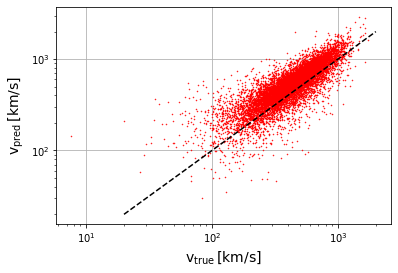

avg correlation = 0.8443810436917607


In [29]:
plt.loglog(vnet/1e5,vnet_itp/1e5,'r.',markersize=1)
plt.xlabel(r'$\rm v_{true}\, [km/s]$', fontsize=14)
plt.ylabel(r'$\rm v_{pred}\, [km/s]$', fontsize=14)
plt.plot([20,2e3],[20,2e3],'k--')
plt.grid()
plt.show()
print ('avg correlation =', np.corrcoef(vnet,vnet_itp)[0][1])

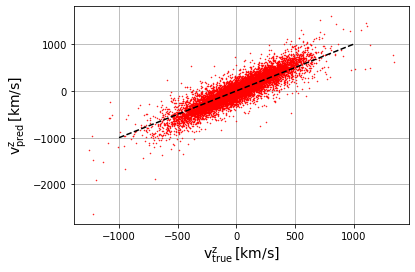

avg correlation = 0.9000211993332726


In [30]:
plt.plot(vz/1e5,vz_itp/1e5,'r.',markersize=1)
plt.xlabel(r'$\rm v^z_{true}\, [km/s]$', fontsize=14)
plt.ylabel(r'$\rm v^z_{pred}\, [km/s]$', fontsize=14)
plt.plot([-1e3,1e3],[-1e3,1e3],'k--')
plt.grid()
plt.show()
print ('avg correlation =', np.corrcoef(vz,vz_itp)[0][1])